In [24]:
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/plotting.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/disturbances.jl")
include("../scripts/ps_analysis.jl");
using FFTW
using LinearAlgebra
using Statistics

In [2]:
border, scale_factor = import_border("../data/borders/border.json")

dx = 0.005
mesh = get_grid(border, dx); # renamed to be able to use the grid function for plotting

In [3]:
# compute or load grid parameters
contmod = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=10,
    dmax = 2*dx, patch=1900.0, bmin=52.0, tau=5.0e-6);


  3.494960 seconds (3.77 M allocations: 16.983 GiB, 7.55% gc time, 10.11% compilation time)
  2.973820 seconds (4.27 M allocations: 1.250 GiB, 13.27% gc time, 58.24% compilation time)


In [4]:
temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = contmod.p
#hm_plot(contmod, temp, borders=[border])

14597-element Vector{Float64}:
  -1399.2104623253165
   -762.6158392501743
    840.0810711245915
   2938.07704624859
  -8631.195352614322
 -12515.76116003866
 -17954.07840257145
 -22428.283210386104
 -24119.504756061186
  -2304.1265991239393
  -1976.7152665298006
   -943.240004840646
   1850.5589584161603
      ⋮
   -844.5143517243979
  -1066.7790844647718
  -1306.1650909486928
  -1459.3218402304599
   -474.29149461326625
   -528.7666586486707
   -699.9379307755565
   -900.0315467985939
  -1127.5418488970813
   -358.7067282656392
   -461.33881746293844
   -568.2136003900353

In [30]:
# Perform a fast fourier transform than remove "small" contributions than do the inverse transform

thres = 0.007
thres2 = 0.3
thres3 = 0.03

bxft = fft(reshape(contmod.bx,contmod.Ny, contmod.Nx))
bxft[abs.(bxft) .< thres*maximum(abs.(bxft))] .= 0
println(sum(abs.(bxft) .> 0) / sum(contmod.bx .> 0))
bx2 = vec(ifft(bxft))

byft = fft(reshape(contmod.by,contmod.Ny, contmod.Nx))
byft[abs.(byft) .< thres*maximum(abs.(byft))] .= 0
println(sum(abs.(byft) .> 0) / sum(contmod.by .> 0))
by2 = vec(ifft(bxft))


temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = contmod.p
pft = fft(reshape(temp, contmod.Ny, contmod.Nx))
pft[abs.(pft) .< thres2 * maximum(abs.(pft))] .= 0
println(sum(abs.(pft) .> 0) / sum(temp .> 0))
p2 = vec(ifft(pft))
#println(sum(imag.(p2)))

mft = fft(reshape(contmod.m, contmod.Ny, contmod.Nx))
mft[abs.(mft) .< thres3*maximum(abs.(mft))] .= 0
println(sum(abs.(mft) .> 0) / sum(contmod.m .> 0))
m2 = vec(ifft(mft))
#println(sum(real.(m2)))
#println(sum(contmod.m))


dft = fft(reshape(contmod.d, contmod.Ny, contmod.Nx))
dft[abs.(dft) .< thres3*maximum(abs.(dft))] .= 0
println(sum(abs.(dft) .> 0) / sum(contmod.d .> 0))
d2 = vec(ifft(dft));
#println(sum(real.(d2)))
#println(sum(contmod.d))
#sum(real.(p2))
#hm_plot(contmod, real.(p2), borders=[border])

0.037033894710049635
0.037033894710049635
0.04878048780487805
0.052058343729008735
0.03386382132200018


-9.313225746154785e-10

In [17]:
# get stable solution
compute_stable_sol!(contmod, interval = 10000, Niter = 250000, tol = 1e-7);

[10000.0 7.328706000730989e-5]
[20000.0 2.296537729229442e-5]
[30000.0 8.50722465695064e-6]
[40000.0 5.117974987700613e-6]
[50000.0 3.448676757611402e-6]
[60000.0 2.454400231166609e-6]
[70000.0 1.8231819836067586e-6]
[80000.0 1.4207368509433493e-6]
[90000.0 1.1641277835039432e-6]
[100000.0 1.0006691575359383e-6]
[110000.0 8.966544253752318e-7]
[120000.0 8.305195347002581e-7]
[130000.0 7.884933590496246e-7]
[140000.0 7.61797420700816e-7]
[150000.0 7.44843709155063e-7]
[160000.0 7.340786246645692e-7]
[170000.0 7.272437857475111e-7]
[180000.0 7.229045519974164e-7]
[190000.0 7.201498033460041e-7]
[200000.0 7.184010007987851e-7]
[210000.0 7.17290819629568e-7]
[220000.0 7.165860579361194e-7]
[230000.0 7.161386640364142e-7]
[240000.0 7.158546534435928e-7]
[250000.0 7.156743602187987e-7]
 27.322929 seconds (3.56 M allocations: 81.753 GiB, 6.50% gc time, 1.53% compilation time)


In [18]:
# Add perturbation around generator 1
# Run only ONCE as it directly changes the distribution of p!
dp = add_local_disturbance!(contmod, dm.coord[1,:], -9.0, 0.02, dx);

In [19]:
ts, thetas, omegas = perform_dyn_sim(contmod, interval=2,
    Ndt=2500, dt=0.01, method="crank-nicolson");

Total time: 25.0
NIter: 2 Avg. Omega: -0.003986307112662954
NIter: 4 Avg. Omega: -0.006493383121687481
NIter: 6 Avg. Omega: -0.008176493634063916
NIter: 8 Avg. Omega: -0.00977502966353556
NIter: 10 Avg. Omega: -0.011639823602461219
NIter: 12 Avg. Omega: -0.013682613233791578
NIter: 14 Avg. Omega: -0.015803130980102532
NIter: 16 Avg. Omega: -0.018045207885757378
NIter: 18 Avg. Omega: -0.01980333572750194
NIter: 20 Avg. Omega: -0.02065072922764532
NIter: 22 Avg. Omega: -0.020971408258554956
NIter: 24 Avg. Omega: -0.021715921968001296
NIter: 26 Avg. Omega: -0.023276050324460604
NIter: 28 Avg. Omega: -0.02514278756346923
NIter: 30 Avg. Omega: -0.026498295543960753
NIter: 32 Avg. Omega: -0.027535664870815425
NIter: 34 Avg. Omega: -0.02885254158667365
NIter: 36 Avg. Omega: -0.03045873095626167
NIter: 38 Avg. Omega: -0.03230698137776775
NIter: 40 Avg. Omega: -0.03455914230425185
NIter: 42 Avg. Omega: -0.03711954163586538
NIter: 44 Avg. Omega: -0.03980721256698382
NIter: 46 Avg. Omega: -0.0424

NIter: 378 Avg. Omega: -0.10178093575478644
NIter: 380 Avg. Omega: -0.10391781674787082
NIter: 382 Avg. Omega: -0.10564489563542737
NIter: 384 Avg. Omega: -0.10691342024136555
NIter: 386 Avg. Omega: -0.10792936763682974
NIter: 388 Avg. Omega: -0.10903155233953107
NIter: 390 Avg. Omega: -0.1104022769982073
NIter: 392 Avg. Omega: -0.11186678019978241
NIter: 394 Avg. Omega: -0.11309157964629427
NIter: 396 Avg. Omega: -0.11389682145543156
NIter: 398 Avg. Omega: -0.11435295839358543
NIter: 400 Avg. Omega: -0.11485639299765253
NIter: 402 Avg. Omega: -0.11553942505423692
NIter: 404 Avg. Omega: -0.1164363469891838
NIter: 406 Avg. Omega: -0.11767761312799785
NIter: 408 Avg. Omega: -0.11883882998131044
NIter: 410 Avg. Omega: -0.1196612152387898
NIter: 412 Avg. Omega: -0.1205271301266789
NIter: 414 Avg. Omega: -0.12168847768240329
NIter: 416 Avg. Omega: -0.1231465373745733
NIter: 418 Avg. Omega: -0.12443507035162668
NIter: 420 Avg. Omega: -0.12546849880913938
NIter: 422 Avg. Omega: -0.12644171750

NIter: 754 Avg. Omega: -0.13155214569592705
NIter: 756 Avg. Omega: -0.13212824020435945
NIter: 758 Avg. Omega: -0.1325126904749837
NIter: 760 Avg. Omega: -0.13271124577080676
NIter: 762 Avg. Omega: -0.13276709643926352
NIter: 764 Avg. Omega: -0.13286646278798805
NIter: 766 Avg. Omega: -0.13304763672434827
NIter: 768 Avg. Omega: -0.13323606149627348
NIter: 770 Avg. Omega: -0.1335196565438105
NIter: 772 Avg. Omega: -0.13383090225839742
NIter: 774 Avg. Omega: -0.13394883631644972
NIter: 776 Avg. Omega: -0.13394643708995532
NIter: 778 Avg. Omega: -0.13406545896055624
NIter: 780 Avg. Omega: -0.1343351572734546
NIter: 782 Avg. Omega: -0.13465522164750876
NIter: 784 Avg. Omega: -0.13504047230201804
NIter: 786 Avg. Omega: -0.13545147186807174
NIter: 788 Avg. Omega: -0.1358853819138826
NIter: 790 Avg. Omega: -0.13632693948257338
NIter: 792 Avg. Omega: -0.136720446036343
NIter: 794 Avg. Omega: -0.13721300016657265
NIter: 796 Avg. Omega: -0.13782171369592694
NIter: 798 Avg. Omega: -0.138495843506

NIter: 1494 Avg. Omega: -0.14620109907901743
NIter: 1496 Avg. Omega: -0.1462812274278714
NIter: 1498 Avg. Omega: -0.14631632947104223
NIter: 1500 Avg. Omega: -0.14636798631645448
NIter: 1502 Avg. Omega: -0.1465039999866654
NIter: 1504 Avg. Omega: -0.14668321767659595
NIter: 1506 Avg. Omega: -0.14686773498538885
NIter: 1508 Avg. Omega: -0.1470205577514197
NIter: 1510 Avg. Omega: -0.1471271693793087
NIter: 1512 Avg. Omega: -0.14717144534308174
NIter: 1514 Avg. Omega: -0.14719306348773736
NIter: 1516 Avg. Omega: -0.14726969841202248
NIter: 1518 Avg. Omega: -0.14734573311696847
NIter: 1520 Avg. Omega: -0.14737558165543996
NIter: 1522 Avg. Omega: -0.14737262029381762
NIter: 1524 Avg. Omega: -0.14733394179434545
NIter: 1526 Avg. Omega: -0.14729030493882914
NIter: 1528 Avg. Omega: -0.14728893131139087
NIter: 1530 Avg. Omega: -0.14732397104006464
NIter: 1532 Avg. Omega: -0.14735925579641326
NIter: 1534 Avg. Omega: -0.1473844188488437
NIter: 1536 Avg. Omega: -0.14742703017652453
NIter: 1538 Avg

NIter: 1862 Avg. Omega: -0.14868296604100853
NIter: 1864 Avg. Omega: -0.14856977832139373
NIter: 1866 Avg. Omega: -0.14849889623180812
NIter: 1868 Avg. Omega: -0.1484627503800873
NIter: 1870 Avg. Omega: -0.14845456936125676
NIter: 1872 Avg. Omega: -0.14844955298498383
NIter: 1874 Avg. Omega: -0.14842867683030414
NIter: 1876 Avg. Omega: -0.1484021123104881
NIter: 1878 Avg. Omega: -0.14840099132680576
NIter: 1880 Avg. Omega: -0.14843555353529173
NIter: 1882 Avg. Omega: -0.14850224767645392
NIter: 1884 Avg. Omega: -0.14858440167774237
NIter: 1886 Avg. Omega: -0.14865759569787942
NIter: 1888 Avg. Omega: -0.14869808641165908
NIter: 1890 Avg. Omega: -0.14871214865019228
NIter: 1892 Avg. Omega: -0.1487382322085587
NIter: 1894 Avg. Omega: -0.148794700476706
NIter: 1896 Avg. Omega: -0.14883849812568326
NIter: 1898 Avg. Omega: -0.1488679267708752
NIter: 1900 Avg. Omega: -0.14888153864310524
NIter: 1902 Avg. Omega: -0.1488738310472213
NIter: 1904 Avg. Omega: -0.14887263950239663
NIter: 1906 Avg. 

NIter: 2230 Avg. Omega: -0.1505165749079826
NIter: 2232 Avg. Omega: -0.15048552143329708
NIter: 2234 Avg. Omega: -0.15045914975953475
NIter: 2236 Avg. Omega: -0.15042874053429162
NIter: 2238 Avg. Omega: -0.15039442608206308
NIter: 2240 Avg. Omega: -0.1503535610962887
NIter: 2242 Avg. Omega: -0.15031399240616775
NIter: 2244 Avg. Omega: -0.15030083126897875
NIter: 2246 Avg. Omega: -0.1502962881713213
NIter: 2248 Avg. Omega: -0.15028484301267253
NIter: 2250 Avg. Omega: -0.1502594713791397
NIter: 2252 Avg. Omega: -0.15023181818299555
NIter: 2254 Avg. Omega: -0.15022718275124022
NIter: 2256 Avg. Omega: -0.1502428868743206
NIter: 2258 Avg. Omega: -0.15028206505443814
NIter: 2260 Avg. Omega: -0.15031268344971052
NIter: 2262 Avg. Omega: -0.15032335838132807
NIter: 2264 Avg. Omega: -0.1503104563001905
NIter: 2266 Avg. Omega: -0.15030232085597978
NIter: 2268 Avg. Omega: -0.15031314557715658
NIter: 2270 Avg. Omega: -0.15033186594012704
NIter: 2272 Avg. Omega: -0.1503502895789469
NIter: 2274 Avg. 

In [31]:
# recreate a contmodel and change the parameters to their reduced version
contmod2 = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=10,
    dmax = 2*dx, patch=1900.0, bmin=52.0, tau=5.0e-6);

contmod2.p = real.(p2[contmod.isgrid])
contmod2.d = real(d2)
contmod2.m = real.(m2)
contmod2.bx = real.(bx2)
contmod2.by = real.(by2);

  2.810474 seconds (1.34 M allocations: 16.848 GiB, 5.03% gc time, 0.00% compilation time)
  0.871746 seconds (3.82 k allocations: 1.011 GiB, 4.04% gc time)


In [32]:
# get stable solution
compute_stable_sol!(contmod, interval = 10000, Niter = 250000, tol = 1e-7);

[10000.0 4.1311882275296696e-5]
[20000.0 2.7064011920985287e-5]
[30000.0 2.5588816790711455e-5]
[40000.0 2.443877447178e-5]
[50000.0 2.3697842163716842e-5]
[60000.0 2.3246974291124545e-5]
[70000.0 2.2974733790759316e-5]
[80000.0 2.2809049589289643e-5]
[90000.0 2.2707132341093228e-5]
[100000.0 2.264386561989795e-5]
[110000.0 2.2604329754649655e-5]
[120000.0 2.2579512564124826e-5]
[130000.0 2.2563889503501855e-5]
[140000.0 2.2554036616995177e-5]
[150000.0 2.254781585842025e-5]
[160000.0 2.2543885647596795e-5]
[170000.0 2.2541401562214958e-5]
[180000.0 2.2539831118884024e-5]
[190000.0 2.253883812919355e-5]
[200000.0 2.253821021547253e-5]
[210000.0 2.2537813131329187e-5]
[220000.0 2.2537562011315515e-5]
[230000.0 2.2537403197908645e-5]
[240000.0 2.253730276091659e-5]
[250000.0 2.253723924461326e-5]
 26.553465 seconds (2.26 M allocations: 81.680 GiB, 4.11% gc time)


In [33]:
ts, thetas2, omegas2 = perform_dyn_sim(contmod, interval=2,
    Ndt=1000, dt=0.01, method="crank-nicolson");

Total time: 10.0
NIter: 2 Avg. Omega: -0.021772654683447044
NIter: 4 Avg. Omega: -0.03938007246400951
NIter: 6 Avg. Omega: -0.049244428935466954
NIter: 8 Avg. Omega: -0.056928312444978355
NIter: 10 Avg. Omega: -0.06413974946226135
NIter: 12 Avg. Omega: -0.06811027844246462
NIter: 14 Avg. Omega: -0.07494658613959691
NIter: 16 Avg. Omega: -0.08266767913117133
NIter: 18 Avg. Omega: -0.09191340870127457
NIter: 20 Avg. Omega: -0.101888471417259
NIter: 22 Avg. Omega: -0.11134872982817391
NIter: 24 Avg. Omega: -0.11994501231233891
NIter: 26 Avg. Omega: -0.1295943643896965
NIter: 28 Avg. Omega: -0.13868076359046808
NIter: 30 Avg. Omega: -0.14706360898112097
NIter: 32 Avg. Omega: -0.15535865276310853
NIter: 34 Avg. Omega: -0.1641625226150906
NIter: 36 Avg. Omega: -0.17246396370092368
NIter: 38 Avg. Omega: -0.17900916392893895
NIter: 40 Avg. Omega: -0.18730350005079488
NIter: 42 Avg. Omega: -0.19637707212820693
NIter: 44 Avg. Omega: -0.20393078027386405
NIter: 46 Avg. Omega: -0.21153295709957146

LoadError: InterruptException:

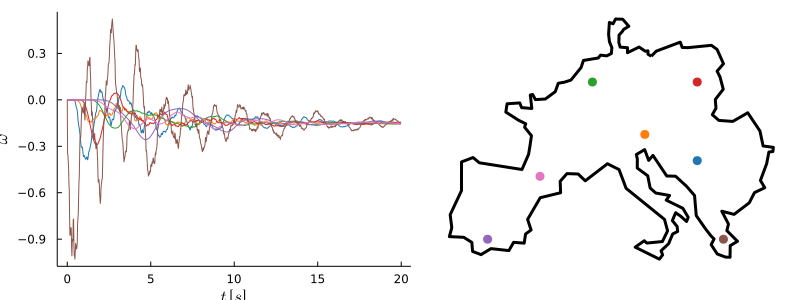

In [26]:
# compare
c = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400] / scale_factor
time_plot(contmod, ts, omegas, c, borders = [border], tstart = 0.0, tend = 20.0)


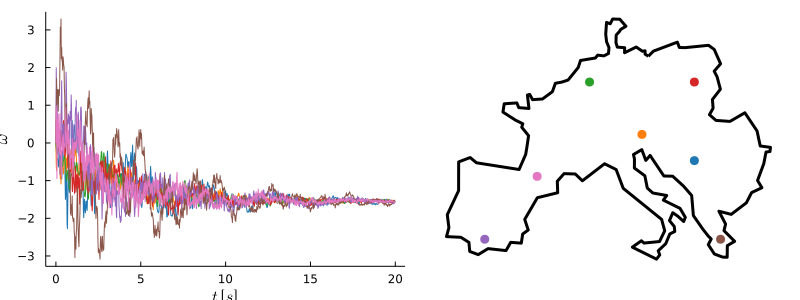

In [25]:
c = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400] / scale_factor
time_plot(contmod, ts, omegas2, c, borders = [border], tstart = 0.0, tend = 20.0)